## Recuperación de Información
# Práctica 1 &mdash; Motores de búsqueda
### Autores: Álvaro José Álvarez Arranz y Bayron Portuguez Castillo

In [71]:
import numpy as np
import math
from tabulate import tabulate
#np.seterr(divide='ignore', invalid='ignore')

# 1. Funciones de ranking no supervisado.

Dada una pequeña colección "de juguete", calcular el ranking de búsqueda para varias consultas según las siguientes funciones de ranking no supervisado:

<ol type="a">
<li> Coseno TF-IDF (modelo vectorial).
<li> BM25.
<li> Query likelihood.
</ol>

### Definir las funciones de ranking a continuación.

####VMS

In [72]:
class VSM:
  def __init__(self, freqvector, docfreqs):
    self.freqvector = freqvector
    self.docfreqs = docfreqs

  def search(self, q):
    # Calculamos los cosenos de todos los documentos.
    ranking = [(url, self.dotproduct(url, q) / self.module(url)) for url in self.freqvector]
    # Eliminamos los documentos con coseno = 0.
    ranking = [(url, cos) for url, cos in ranking if cos > 0]
    # Ordenamos.
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def dotproduct(self, url, q):
    _dotproduct = 0
    for word in q:
      _dotproduct += self.idf(word)*self.tf(word, url)
    return _dotproduct

  def module(self, url):
    mod = 0 # Módulo de la url
    for word in self.freqvector[url].keys():
      mod += (self.idf(word) * self.tf(word, url)) ** 2 # Aumento del módulo
    return math.sqrt(mod) # Devolvemos la raiz cuadrada

  def tf(self, word, url):
    try:
        if self.freqvector is not None and url in self.freqvector:
            word_freq = self.freqvector[url].get(word)
            if word_freq is not None:
                return 1 + math.log2(word_freq)
    except TypeError:
        pass
    return 0

  def idf(self,word):
    return math.log2(len(self.freqvector)/self.docfreqs.get(word))

####BM25

In [73]:
# Nota: cuando una palabra aparece en más de la mitad de la colección, resulta un score BM25 negativo.
# Una forma de evitarlo es tomar un número mínimo de documentos como |D|, es decir usar por ejemplo
# |D| = max(20, len(freqvector))
class BM25:
  def __init__(self, freqvector, docfreqs, b, k):
    self.freqvector = freqvector
    self.docfreqs = docfreqs
    self.b = b
    self.k = k
    self.average_d = self.calc_average_d()

  def search(self, q):
    ranking = []

    for url in self.freqvector:
      rank = 0
      for word in q:
        rank += (self.numerator(url,word)/self.denominator(url,word)) * self.rsj(word)
      ranking.append([url,rank])

    # Eliminamos los documentos con coseno = 0.
    ranking = [(url, cos) for url, cos in ranking if cos > 0]

    # Ordenamos.
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def numerator(self, url, q):
    num = 0
    if self.freqvector is not None and url in self.freqvector:
      word_freq = self.freqvector[url].get(q)
      if word_freq is not None:
        num = (self.k + 1) * word_freq
      else:
        num = 0
    return num

  def denominator(self, url, q):
    den = 0
    if self.freqvector is not None and url in self.freqvector:
      word_freq = self.freqvector[url].get(q)
      if word_freq is not None:
        den += self.k * (1 - self.b + (self.b * sum(self.freqvector[url].values())/self.average_d)) + word_freq
      else:
        den += self.k * (1 - self.b + (self.b * (sum(self.freqvector[url].values())/self.average_d))) + 0
    return den

  def rsj(self, word):
    numerator = max(20,len(self.freqvector)) - self.docfreqs.get(word)#+0.5# + self.b
    denominator = self.docfreqs.get(word)#+0.5# + self.b
    return math.log2(numerator/denominator)

  def calc_average_d(self):
    average_d = []
    for url in self.freqvector:
      average_d.append(sum(self.freqvector[url].values()))
    self.average_d = np.average(average_d)
    return self.average_d

####QLD

In [74]:
class QLD:
  def __init__(self, freqvector, wordfreqs, mu):
    self.freqvector = freqvector
    self.wordfreqs = wordfreqs
    self.mu = mu
    #self.D

  def search(self, q):
    ranking = []

    for url in self.freqvector.keys():
      rank = 1.0

      # Obtenemos el tamaño del documento
      len_doc = sum(self.freqvector[url].values())
      for w in q:
        # Calculamos el valor p-gorro de la palabra
        p_w = self.p_c(w)

        # Obtenemos la frecuencia de la palabra en el documento
        frec_w_d = self.freqvector[url].get(w, 0)

        # Calculamos su rango con suavizado Dirichlet
        rank *= (frec_w_d + self.mu * p_w)/(len_doc + self.mu)
      ranking.append([url, rank])

    # Eliminamos los documentos con valor menor que cero
    ranking = [(url, cos) for url, cos in ranking if cos > 0]

    # Ordenamos por orden de rango
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def p_c(self, w):
    '''
      Función que devuelve la probabilidad de la palabra 'w'.
      Necesaria para el suavizado de Dirichlet
    '''
    sum_freq = np.array([self.freqvector[url].get(w, 0) for url in self.freqvector.keys()]).sum()
    len_total = 0
    for url in self.freqvector.keys():
      for w in self.freqvector[url].keys():
        len_total += self.freqvector[url][w]

    return sum_freq / len_total

### Programa de prueba

##### 1.  Colección

In [75]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import Counter
import re

# La colección: una pequeña lista de URLs web.
urls = ["https://en.wikipedia.org/wiki/Age_of_Enlightenment",
        "https://en.wikipedia.org/wiki/Rationalism",
        "https://en.wikipedia.org/wiki/Scientific_Revolution",
        "https://en.wikipedia.org/wiki/French_Revolution",
        "https://en.wikipedia.org/wiki/Winner%27s_curse",
        "https://en.wikipedia.org/wiki/Simpson%27s_paradox",
        "https://en.wikipedia.org/wiki/Friendship_paradox",
        "https://en.wikipedia.org/wiki/Condorcet_paradox",
        "https://en.wikipedia.org/wiki/Paradox_of_value",
        "https://en.wikipedia.org/wiki/Ship_of_Theseus"
       ]

# Leemos los documentos y quitamos las marcas HTML.
texts = [BeautifulSoup(urlopen(url).read(), "lxml").text.lower() for url in urls]

# Una lista ad-hoc de stopwords.
stoplist = ["also", "could", "p", "pp", "th", "however", "one", "two", "many", "i", "de", "la", "me", "my", "myself", "the", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

##### 2.  Extracción y construcción de bag of words

In [76]:
# Nos abstraemos de los detalles reales de indexación, y utilizaremos un manejo muy simplificado del texto.

# Vector de frecuencias para todos los documentos de la colección, usando la subclase de diccionario collections.Counter.
# Para cada documento, separamos el texto en lista de palabras, y Counter genera un diccionario palabra:frecuencia.
# Se construye un diccionario url -> word -> count (se denomina un "índice forward").
freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text) if word not in stoplist]) for url, text in zip(urls, texts)}

# Guardamos el vocabulario (el conjunto de todas las palabras que apaercen en los documentos de la colección).
vocabulary = set()
for word in freqvector.values(): vocabulary.update(word)

# Document frequency de cada palabra del vocabulario: nº de documentos que contienen la palabra.
docfreqs = {word:len([url for url in freqvector if word in freqvector[url]]) for word in vocabulary}

# Frecuencia total para cada palabra del vocabulario: nº total de apariciones en la colección.
wordfreqs = {word:sum([freqvector[url][word] for url in freqvector if word in freqvector[url]]) for word in vocabulary}

##### 3.  Consultas de prueba

In [79]:
# Probamos tres consultas.
for q in [['descartes', 'montesquieu'], ['thought', 'experiment', 'identity'], ['market', 'paradox']]:
    print('\n+-------------------------------------------------------------+')
    print("\033[1m" + f'Query: {q}'+ "\033[0m")

    # Modelos
    vsm_results = VSM(freqvector, docfreqs).search(q)
    bm25_results = BM25(freqvector, docfreqs, b=0.5, k=1).search(q)
    qld_results = QLD(freqvector, wordfreqs, mu=3000).search(q)

    # Imprimir resultados utilizando tabulate
    print("\033[1m" + '\nModelo vectorial'+ "\033[0m")
    vsm_formatted = [(score, url) for url, score in vsm_results]
    print(tabulate(vsm_formatted, headers=["Score", "URL"]))

    print("\033[1m" + '\nBM25'+ "\033[0m")
    bm25_formatted = [(score, url) for url, score in bm25_results]
    print(tabulate(bm25_formatted, headers=["Score", "URL"]))

    print("\033[1m" + '\nQuery likelihood + Dirichlet'+ "\033[0m")
    qld_formatted = [(score, url) for url, score in qld_results]
    print(tabulate(qld_formatted, headers=["Score", "URL"]))


+-------------------------------------------------------------+
Query: ['descartes', 'montesquieu']

Modelo vectorial
    Score  URL
---------  ---------------------------------------------------
0.0459181  https://en.wikipedia.org/wiki/Rationalism
0.0453778  https://en.wikipedia.org/wiki/Age_of_Enlightenment
0.0196601  https://en.wikipedia.org/wiki/Scientific_Revolution
0.0175874  https://en.wikipedia.org/wiki/French_Revolution
0.0124401  https://en.wikipedia.org/wiki/Ship_of_Theseus

BM25
  Score  URL
-------  ---------------------------------------------------
8.62961  https://en.wikipedia.org/wiki/Age_of_Enlightenment
4.00249  https://en.wikipedia.org/wiki/French_Revolution
3.88065  https://en.wikipedia.org/wiki/Rationalism
3.29283  https://en.wikipedia.org/wiki/Scientific_Revolution
2.38232  https://en.wikipedia.org/wiki/Ship_of_Theseus

Query likelihood + Dirichlet
      Score  URL
-----------  ---------------------------------------------------
2.59226e-07  https://en.wikipedia

# 2. Búsqueda con funciones no supervisadas implementadas en la librería PyTerrier.

In [80]:
# Utlizamos la librería de motor de búsqueda PyTerrier.
!pip install python-terrier
!pip install ir-measures
!pip install lightgbm==2.0.3

### Ejemplo

In [81]:
import pyterrier as pt
from pyterrier.measures import *
if not pt.started(): pt.init()

def printsearch(name, model, q):
  print('\n' + name)
  # Eliminamos todas las columnas del dataframe menos score y docno
  print((model).search(q)[['score', 'docno']].to_string(index=False))

def eval(names, models, queries, qrels, metrics, sort=[], baseline=None):
  # La clase Experiment ejecuta rankers sobre una batería de consultas, y calcula métricas.
  # El parámetro "baseline" hace que se añadan p-valores (y nº de consultas ganadas/perdidad) respecto a uno de los rankers.
  # Con el parámetro "sort" se ordena la tabla de métricas la métrica que se indique.
  print(pt.Experiment(models, queries, qrels, metrics, names, baseline=baseline).sort_values(str(sort), ascending=False).to_string(index=False))

# Accedemos a una colección "Vaswani" ya construida e indexada en PyTerrier.
dataset = pt.datasets.get_dataset('vaswani')
index = pt.IndexFactory.of(dataset.get_index())
#index = pt.IndexFactory.of(pt.IterDictIndexer("./vaswani_index").index(pt.get_dataset('vaswani').get_corpus_iter()))
queries = dataset.get_topics()
qrels = dataset.get_qrels()

# Sacamos una consulta cualquiera del conjunto de datos para probar los rankers.
q = queries[queries.qid=='5']['query'].values[0]

# Creamos y probamos rankers no supervisados por VSM, BM25, QLD y otros.
vsm = pt.BatchRetrieve(index, wmodel='TF_IDF')
bm25 = pt.BatchRetrieve(index, wmodel='BM25') # Debido a un error se cambia a BM25
qld = pt.BatchRetrieve(index, wmodel='DirichletLM')
pl2 = pt.BatchRetrieve(index, wmodel='PL2')
dph = pt.BatchRetrieve(index, wmodel='DPH')

#<---------------------------------------------------------------------------->#
'''NUEVOS MODELOS'''
hiemstra = pt.BatchRetrieve(index, wmodel='Hiemstra_LM')
cm = pt.BatchRetrieve(index, wmodel='CoordinateMatch')
mdl2 = pt.BatchRetrieve(index, wmodel='MDL2')
pl2 = pt.BatchRetrieve(index, wmodel='PL2')

#<---------------------------------------------------------------------------->#

print('Query:', q)
# El operador "%n" de PyTerrier pide al modelo que produzca sólo el top n del ranking.
printsearch('Modelo vectorial', vsm%10, q)
printsearch('BM25', bm25%10, q)
printsearch('Query likelihood Dirichlet', qld%10, q)
#<---------------------------------------------------------------------------->#
printsearch('Hiemstra LM', hiemstra%10, q)
printsearch('CoordinateMatch', cm%10, q)
printsearch('MLD2', mdl2%10, q)
printsearch('PL2', pl2%10, q)
#<---------------------------------------------------------------------------->#
# Calculamos varias métricas
eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH','Hiemstra LM','CoordinateMatch','MLD2','PL2'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50, hiemstra%50, cm%50, mdl2%10, pl2%10],
     queries, qrels, [P@10, nDCG, nDCG@10, RR, Rprec, Bpref, Success@10, AP], baseline=0, sort=nDCG@10)

Query: use of programs in engineering testing of computers

Modelo vectorial
    score docno
14.442821  1586
12.833733 11429
10.506225  7875
 9.889541  3559
 9.809790  2290
 9.737880  5130
 9.486759  4307
 9.451995  4308
 9.403773  9165
 9.344073 10156

BM25
    score docno
26.192890  1586
23.252472 11429
18.996809  7875
18.066157  3559
17.749907  2290
17.594194  5130
17.129366  4307
17.090606  4308
17.045979  9165
16.895468 10156

Query likelihood Dirichlet
   score docno
3.305896  1586
3.287824  2373
3.002635 11429
2.937968  3559
2.570817  4307
2.495430  4709
2.434525   276
2.379995  5538
2.292910  7875
2.283731  4308

Hiemstra LM
    score docno
15.650767  1586
12.653913 11429
11.458081  3559
10.917674  2290
10.510299  7875
10.429062  5130
10.270615 10156
 9.916670  9165
 9.522880  2927
 9.504814  2675

CoordinateMatch
 score docno
   3.0  1586
   3.0  5429
   3.0  9165
   3.0 11429
   2.0   140
   2.0   148
   2.0   396
   2.0   521
   2.0   593
   2.0   884

MLD2
    score docno
1

### Ejercicio: probar más modelos no supervisados y métricas de PyTerrier

La lista completa de rankers de PyTerrier está disponible en http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html.

La lista de métricas en https://pyterrier.readthedocs.io/en/latest/experiments.html.

In [82]:
import pyterrier as pt
from pyterrier.measures import *
# Probar BB2, InL2, LGD
if not pt.started(): pt.init()

def printsearch(name, model, q):
  print('\n' + name)
  # Eliminamos todas las columnas del dataframe menos score y docno
  print((model).search(q)[['score', 'docno']].to_string(index=False))

def eval(names, models, queries, qrels, metrics, sort=[], baseline=None):
  # La clase Experiment ejecuta rankers sobre una batería de consultas, y calcula métricas.
  # El parámetro "baseline" hace que se añadan p-valores (y nº de consultas ganadas/perdidad) respecto a uno de los rankers.
  # Con el parámetro "sort" se ordena la tabla de métricas la métrica que se indique.
  print(pt.Experiment(models, queries, qrels, metrics, names, baseline=baseline).sort_values(str(sort), ascending=False).to_string(index=False))

# Accedemos a una colección "Vaswani" ya construida e indexada en PyTerrier.
dataset = pt.datasets.get_dataset('vaswani')
index = pt.IndexFactory.of(dataset.get_index())
#index = pt.IndexFactory.of(pt.IterDictIndexer("./vaswani_index").index(pt.get_dataset('vaswani').get_corpus_iter()))
queries = dataset.get_topics()
qrels = dataset.get_qrels()

# Sacamos una consulta cualquiera del conjunto de datos para probar los rankers.
q = queries[queries.qid=='5']['query'].values[0]

#<---------------------------------------------------------------------------->#
'''NUEVOS MODELOS'''
bb2 = pt.BatchRetrieve(index, wmodel='BB2')
inl2 = pt.BatchRetrieve(index, wmodel='InL2')
lgd = pt.BatchRetrieve(index, wmodel='LGD')

#<---------------------------------------------------------------------------->#

print('Query:', q)
#<---------------------------------------------------------------------------->#
printsearch('BB2', bb2%10, q)
printsearch('InL2', inl2%10, q)
printsearch('LGD', lgd%10, q)
#<---------------------------------------------------------------------------->#
print("\n\n")
# Calculamos varias métricas
eval(['BB2', 'InL2', 'LGD'],
     [bb2%50, inl2%50, lgd%50],
     queries, qrels, [P@10, nDCG, nDCG@10, RR, Rprec, Bpref, Success@10, AP], baseline=0, sort=nDCG@10)

Query: use of programs in engineering testing of computers

BB2
    score docno
14.738071  1586
13.229988 11429
10.744531  7875
10.087269  2290
10.023517  9165
 9.991771  5130
 9.881588  4307
 9.857636  3559
 9.799563  4308
 9.761610 10156

InL2
    score docno
12.751108  1586
11.379091 11429
 9.073474  7875
 8.875413  3559
 8.651953  2290
 8.623814  9165
 8.522439  5130
 8.304776  4307
 8.272284  4308
 8.240010 10156

LGD
    score docno
22.804018  1586
20.540319 11429
17.805691  9165
16.700508  5429
16.299616  3559
15.303159  7875
15.059554  5130
14.861279  2290
14.651312  4307
14.476024  2675



name       AP    Rprec    Bpref       RR     P@10     nDCG  nDCG@10  Success@10  AP +  AP -  AP p-value  Rprec +  Rprec -  Rprec p-value  Bpref +  Bpref -  Bpref p-value  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value  Success@10 +  Success@10 -  Success@10 p-value
 BB2 0.254397 0.295466 0.486153 0.716245 0.380645 0.4

***Nota:***

*Se implementan dentro del código de la celda anterior, claramente separado del que ya se brindaba. A continuación, se señalan los rankers y métricas implementados:*
*
* Rankers:
  * Hiemstra_LM
  * CoordinateMatch
  * MLD2
  * PL2
* Métricas:
  * Rprec
  * Bprec
  * Success@10
  * AP

Posteriormente se han añadido los siguientes *rankers* en esta celda:
* BB2
* LGD
* InL2

La tabla resultante de evaluar los diferentes *rankers* es la siguiente:

In [83]:
eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH','Hiemstra LM','CoordinateMatch','MLD2','PL2', 'BB2', 'InL2', 'LGD'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50, hiemstra%50, cm%50, mdl2%10, pl2%10, bb2%50, inl2%50, lgd%50],
     queries, qrels, [P@10, nDCG, nDCG@10, RR, Rprec, Bpref, Success@10, AP], baseline=0, sort=nDCG@10)

                      name       AP    Rprec    Bpref       RR     P@10     nDCG  nDCG@10  Success@10  AP +  AP -   AP p-value  Rprec +  Rprec -  Rprec p-value  Bpref +  Bpref -  Bpref p-value  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value  Success@10 +  Success@10 -  Success@10 p-value
                       BB2 0.254397 0.295466 0.486153 0.716245 0.380645 0.450609 0.463713    0.870968  59.0  25.0 7.814678e-04     19.0     14.0   8.974905e-01     30.0     12.0   4.090251e-01  12.0   9.0    0.272563    23.0     6.0  2.154786e-03    60.0    24.0  8.166929e-03       44.0       24.0     1.960054e-03           0.0           2.0            0.158418
                       LGD 0.244767 0.288223 0.471119 0.708563 0.376344 0.439196 0.455387    0.881720  47.0  40.0 6.040272e-01     22.0     22.0   3.956053e-01     26.0     24.0   4.214606e-01  13.0  15.0    0.605814    26.0    16.0  5.894045e-02    44.0    43.0  8.981909

# 3. Learning to rank con características de texto.

### Ejemplo

In [84]:
import numpy as np
import lightgbm as lgb

# Definimos el vector de características, e indicamos la función de ranking para el primer filtro de candidatos "first stage ranking".
fsr = pt.FeaturesBatchRetrieve(index, controls = {'wmodel': 'BM25'}, features=['SAMPLE', 'WMODEL:DirichletLM', 'WMODEL:PL2'])

# Vamos a usar el modelo GBDT LambdaMART implementado en LightGBM.
# Configuramos el modelo.
lmart = lgb.LGBMRanker(task='train',
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective='lambdarank',
    metric='ndcg',
    # ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    #importance_type='gain',
    verbose=-1,
    num_iterations=10)

# Enganchamos al modelo la salida del filtro de candidatos con su vector de características a utilizar
# en el modelo supervisado.
ltr = fsr >> pt.ltr.apply_learned_model(lmart, form='ltr')

# Particionamos los datos (las consultas) en entrenamiento (60%), validación (20%) y test (20%).
train, validation, test = np.split(queries, [int(.6*len(queries)), int(.8*len(queries))])

# Entrenamos el modelo usando los juicios de relevancia (qrels). Aunque los qrels incluyen los datos de
# test, la función fit sólo utiliza los juicios asociados a las consultas de entrenamiento y validación.
ltr.fit(train, qrels, validation, qrels)

# Ejecutamos el modelo entrenado sobre una consulta y observamos la salida.
printsearch('BM25 + LambdaMART', ltr%10, q)

# Evaluamos y comparamos.
eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH', 'BM25 + LambdaMART'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50, ltr%50],
     test, qrels, [P@10, nDCG, nDCG@10, RR], sort=nDCG@10, baseline=0)

[1]	valid_0's ndcg@1: 0.421053
[2]	valid_0's ndcg@1: 0.578947
[3]	valid_0's ndcg@1: 0.578947
[4]	valid_0's ndcg@1: 0.631579
[5]	valid_0's ndcg@1: 0.526316
[6]	valid_0's ndcg@1: 0.526316
[7]	valid_0's ndcg@1: 0.631579
[8]	valid_0's ndcg@1: 0.631579
[9]	valid_0's ndcg@1: 0.578947
[10]	valid_0's ndcg@1: 0.578947

BM25 + LambdaMART
   score docno
0.326225  1586
0.305987 11429
0.268356  7875
0.268233  3559
0.268233  2290
0.268233  5130
0.239045  4307
0.239045  4308
0.239045  9165
0.239045 10156
                      name       RR     P@10     nDCG  nDCG@10  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value
                      BM25 0.595052 0.252632 0.347720 0.306262   2.0   1.0    0.606020     1.0     0.0      0.330565     7.0     8.0      0.865871        3.0        4.0         0.569843
          Modelo vectorial 0.596739 0.247368 0.347220 0.304047   NaN   NaN         NaN     NaN     NaN           NaN     NaN     NaN 

### Ejercicio: variaciones en learning to rank.

Explorar la configuración de parámetros de LambdaMART.

Probar otros métodos learning to rank de Terrier.

Opcional: probar otras características funcionales.

Intentar conseguir al menos una solución que mejore a todas las del ejemplo anterior.

In [85]:
# Ejemplo de características funcionales custom.
import re
def _features(row):
  content = index.getMetaIndex().getItem('text', row['docid'])
  f1 = len(content)
  f2 = len(re.findall(r"[^\W\d_]+|\d+", content))
  return np.array([f1, f2])

extended_fsr = bm25 >> pt.FeaturesBatchRetrieve(index, ['SAMPLE', 'WMODEL:DirichletLM', 'WMODEL:PL2']) ** pt.apply.doc_features(_features)
extended_ltr = extended_fsr >> pt.ltr.apply_learned_model(lmart, form="ltr")
extended_ltr.fit(train, qrels, validation, qrels)

# Se prueba con el modelo BB2 y se consigue una mejor solución
extended_fsr_h = bb2 >> pt.FeaturesBatchRetrieve(index, ['SAMPLE', 'WMODEL:DirichletLM', 'WMODEL:PL2']) ** pt.apply.doc_features(_features)
extended_ltr_h = extended_fsr_h >> pt.ltr.apply_learned_model(lmart, form="ltr")
extended_ltr_h.fit(train, qrels, validation, qrels)

printsearch('Extended BM25 + LambdaMART', extended_ltr%10, q)
printsearch('Extended BB2 + LambdaMART', extended_ltr_h%10, q)

eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH','Extended BM25 + LambdaMART','BB2 + LambdaMART'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50, extended_ltr%50, extended_ltr_h%50 ], test, qrels,
     [P@10, nDCG, nDCG@10, RR], sort=nDCG@10)

[1]	valid_0's ndcg@1: 0.473684
[2]	valid_0's ndcg@1: 0.473684
[3]	valid_0's ndcg@1: 0.526316
[4]	valid_0's ndcg@1: 0.578947
[5]	valid_0's ndcg@1: 0.578947
[6]	valid_0's ndcg@1: 0.578947
[7]	valid_0's ndcg@1: 0.526316
[8]	valid_0's ndcg@1: 0.526316
[9]	valid_0's ndcg@1: 0.578947
[10]	valid_0's ndcg@1: 0.578947
[1]	valid_0's ndcg@1: 0.473684
[2]	valid_0's ndcg@1: 0.315789
[3]	valid_0's ndcg@1: 0.526316
[4]	valid_0's ndcg@1: 0.526316
[5]	valid_0's ndcg@1: 0.526316
[6]	valid_0's ndcg@1: 0.526316
[7]	valid_0's ndcg@1: 0.526316
[8]	valid_0's ndcg@1: 0.526316
[9]	valid_0's ndcg@1: 0.526316
[10]	valid_0's ndcg@1: 0.526316

Extended BM25 + LambdaMART
   score docno
0.326098  1586
0.326098 11429
0.309260  7875
0.295498  2290
0.295498  5130
0.295498  4307
0.283930  3559
0.283930  4308
0.283930  9165
0.283930  2511

Extended BB2 + LambdaMART
   score docno
0.314480  1586
0.314480 11429
0.226531  7875
0.212769  2290
0.212769  5130
0.212769  4307
0.201200  9165
0.201200  3559
0.201200  4308
0.181840

# 4. Opcional: dense retrieval.

### Ejemplo: obtención y visualización de embeddings.

  Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)
  Using cached smart_open-6.4.0-py3-none-any.whl (57 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


--2024-02-19 22:34:08--  https://huggingface.co/LoganKilpatrick/GoogleNews-vectors-negative300/resolve/main/GoogleNews-vectors-negative300.bin.gz
Resolving huggingface.co (huggingface.co)... 18.238.49.70, 18.238.49.117, 18.238.49.112, ...
Connecting to huggingface.co (huggingface.co)|18.238.49.70|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/b1/89/b189d35444d7ce0d7e26df34136d48e0ea67093c66b4c6ecf41c618c40c33937/21c05ae916a67a4da59b1d006903355cced7de7da1e42bff9f0504198c748da8?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27GoogleNews-vectors-negative300.bin.gz%3B+filename%3D%22GoogleNews-vectors-negative300.bin.gz%22%3B&response-content-type=application%2Fgzip&Expires=1708641248&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODY0MTI0OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9iMS84OS9iMTg5ZDM1NDQ0ZDdjZTBkN2UyNmRmMzQxMzZkNDhlMGVhNj

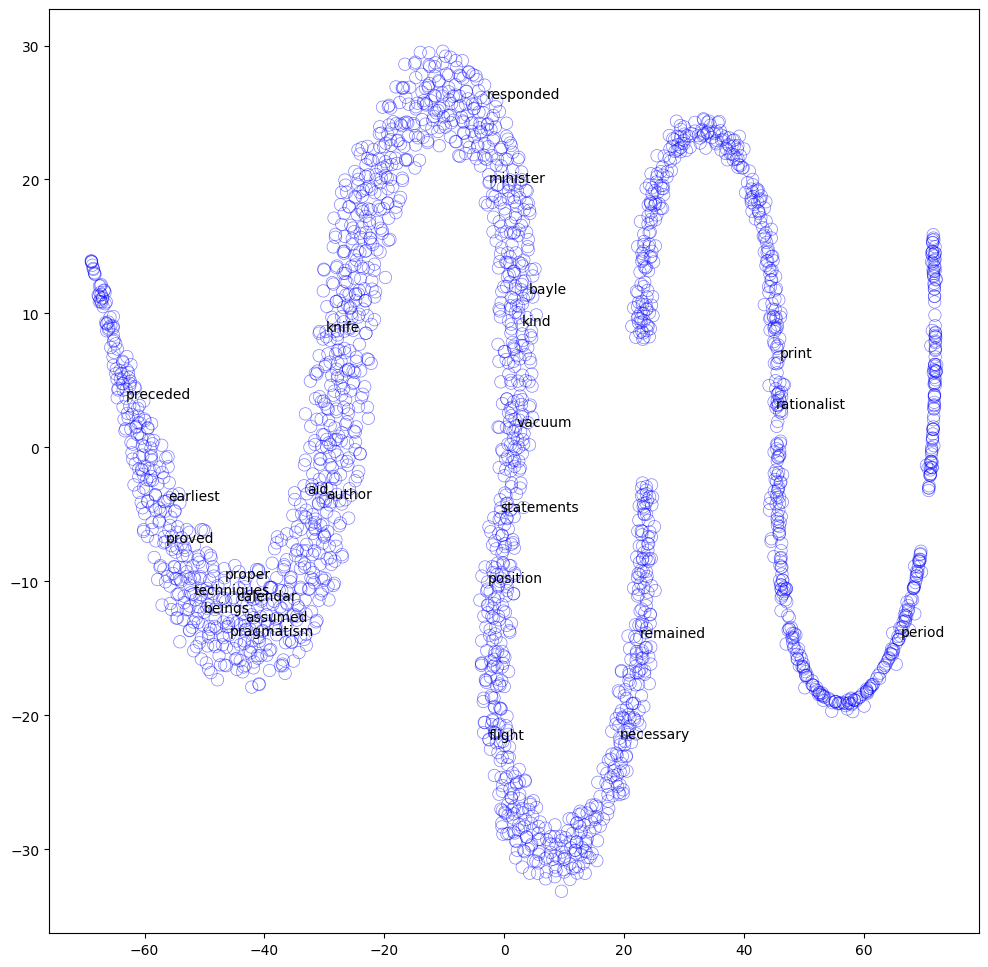

In [86]:
# Extracción de embeddings y embeddings pre-entrenados.
!pip install --upgrade --ignore-installed gensim
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

# Embeddings para la colección de juguete del ejercicio 1 (reutilizando la variable "texts").
words = [[word for word in simple_preprocess(text) if word not in stoplist] for text in texts]
model = Word2Vec(words).wv

!wget https://huggingface.co/LoganKilpatrick/GoogleNews-vectors-negative300/resolve/main/GoogleNews-vectors-negative300.bin.gz
premodel = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

print(model.most_similar(['paradox'], topn=20))
print(premodel.most_similar(['paradox'], topn=20))

def reduce_dimensions(model):
  from sklearn.decomposition import IncrementalPCA  # inital reduction
  from sklearn.manifold import TSNE                 # final reduction
  num_dimensions = 2                                # final num dimensions (2D, 3D, etc)
  tsne = TSNE(n_components=num_dimensions, random_state=0)
  vectors = tsne.fit_transform(np.asarray(model.vectors))
  return [v[0] for v in vectors], [v[1] for v in vectors], np.asarray(model.index_to_key)

def plot(x_vals, y_vals, labels):
  import matplotlib.pyplot as plt
  import random
  plt.figure(figsize=(12, 12))
  plt.scatter(x_vals, y_vals, facecolors='none', edgecolors='b', linewidth=.5, s=80, alpha=.5)
  for i in random.sample(list(range(len(labels))), 25): plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot(*reduce_dimensions(model))

### Ejercicio: dense retrieval con embeddings.

Definir una función de ránking no supervisado basada en embeddings. Utilizar las implementaciones de gensym y la colección de juguete del ejercicio 1, u otras opciones a elección del estudiante.

#### Creación de la clase: ***RankingEmbeddingNS***

In [87]:
from tabulate import tabulate
from gensim.similarities import WordEmbeddingSimilarityIndex
#/****************************************************************************************/#
#           Clase RankingEmbeddingNS (Ranking por Embeddings No Supervisado)               #
#/****************************************************************************************/#
class RankingEmbeddingNS:
    def __init__(self, freqvector, vocabulary, wordfreqs, embedding_size=100, window=5, min_count=1, workers=4):
        """
        Constructor

        Parámetros:
        - freqvector: Diccionario url -> Counter de frecuencias de palabras.
        - vocabulary: Conjunto de palabras en el vocabulario.
        - wordfreqs: Diccionario de frecuencias totales de palabras.
        - embedding_size: Tamaño del espacio de embeddings.
        - window: Tamaño de la ventana para el modelo Word2Vec.
        - min_count: Ignora todas las palabras con frecuencia total inferior a este umbral.
        - workers: Número de hilos para entrenar el modelo.
        """
        self.freqvector = freqvector
        self.vocabulary = vocabulary
        self.wordfreqs = wordfreqs
        self.embedding_size = embedding_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.embedding_model = None
        self.similarity_index = None

        self.train_embedding_model()

    def train_embedding_model(self):
        # Preparar datos para entrenar el modelo Word2Vec
        sentences = [[word for word in freqvector[url] if word in self.vocabulary] for url in self.freqvector]

        # Entrenar modelo Word2Vec
        self.embedding_model = Word2Vec(sentences, vector_size=self.embedding_size, window=self.window,
                                        min_count=self.min_count, workers=self.workers)

        # Construir un índice de similitud basado en embeddings
        self.similarity_index = WordEmbeddingSimilarityIndex(self.embedding_model.wv)

    def rank_documents(self, query, top_n=5):
        """
        Clasificador de documentos en función de su similitud con la consulta.

        Parámetros:
        - query: Lista de palabras que representan la consulta.
        - top_n: Número de documentos principales a devolver.

        Resultado:
        - Lista de tuplas (documento_url, similitud) ordenada por similitud descendente.
        """
        # Obtener el vector de frecuencias de la consulta
        query_vector = [word for word in query if word in self.vocabulary]

        # Verificar si la consulta contiene palabras del vocabulario
        if not query_vector:
            print("La consulta no contiene palabras del vocabulario.")
            return []

        # Calcular similitud de la consulta con cada documento manualmente
        similarities = [self.embedding_model.wv.n_similarity(query_vector, doc_vector) for doc_vector in self.get_document_vectors()]

        # Obtener las claves (URLs) como una lista
        document_keys = list(self.freqvector.keys())

        # Ordenar por similitud descendente
        ranked_documents = sorted(zip(document_keys, similarities), key=lambda x: x[1], reverse=True)

        # Devolver los mejores documentos
        return ranked_documents[:top_n]

    def get_document_vectors(self):
        """
        Obtener los vectores de documentos para todos los documentos en el conjunto de datos.

        Resultado:
        - Una lista de vectores de documentos.
        """
        document_vectors = []

        for url in self.freqvector:
            doc_vector = [word for word in self.freqvector[url] if word in self.vocabulary]
            document_vectors.append(doc_vector)

        return document_vectors


#### Prueba con lista de documentos

In [88]:
# Crear una instancia
ranking_model = RankingEmbeddingNS(freqvector, vocabulary, wordfreqs)

queries = [['descartes', 'montesquieu'], ['thought', 'experiment', 'identity'], ['market', 'paradox']]

# Imprimiendo los resultados del ranking
for i, query in enumerate(queries, start=1):
    result = ranking_model.rank_documents(query, 10)

    result_with_rank = [(f"{idx:02d}", doc, sim) for idx, (doc, sim) in enumerate(result, start=1)]

    print("\033[1m" + f"\nRanking de documentos para la consulta {query}:" + "\033[0m")
    print(tabulate(result_with_rank, headers=["Rank", "Documento", "Similitud"]))


Ranking de documentos para la consulta ['descartes', 'montesquieu']:
  Rank  Documento                                              Similitud
------  ---------------------------------------------------  -----------
    01  https://en.wikipedia.org/wiki/Rationalism              0.104397
    02  https://en.wikipedia.org/wiki/Age_of_Enlightenment     0.0674802
    03  https://en.wikipedia.org/wiki/Friendship_paradox       0.0525574
    04  https://en.wikipedia.org/wiki/Winner%27s_curse         0.0196396
    05  https://en.wikipedia.org/wiki/French_Revolution       -0.0330377
    06  https://en.wikipedia.org/wiki/Simpson%27s_paradox     -0.037053
    07  https://en.wikipedia.org/wiki/Scientific_Revolution   -0.0383304
    08  https://en.wikipedia.org/wiki/Ship_of_Theseus         -0.0686982
    09  https://en.wikipedia.org/wiki/Paradox_of_value        -0.219287
    10  https://en.wikipedia.org/wiki/Condorcet_paradox       -0.251967

Ranking de documentos para la consulta ['thought', 'exper

# 5. Opcional: deep learning to rank.

Aplicar un modelo de deep learning sobre alguno de los conjuntos de datos de los ejercicios anteriores. Por ejemplo, utilizar alguno de los modelos disponibles en PyTerrier.

In [112]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import pyterrier as pt
from pyterrier.transformer import TransformerBase


class MyTransformer(TransformerBase):
    def __init__(self, model_name="bert-base-uncased"):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(model_name)
        self.init_classifier_weights()

    def init_classifier_weights(self):
        torch.nn.init.xavier_uniform_(self.model.classifier.weight)
        if self.model.classifier.bias is not None:
            self.model.classifier.bias.data.fill_(0.01)

    def transform(self, query, document_ids):

		#Definir las semillas aleatorias
        torch.manual_seed(13)
        np.random.seed(13)

        # Tokenizar la consulta y los documentos
        query_tokens = self.tokenizer(query, return_tensors="pt", truncation=True, padding=True)
        #doc_tokens = self.tokenizer(document_texts, return_tensors="pt", truncation=True, padding=True)

        # Calcular la salida del modelo para la consulta y los documentos
        with torch.no_grad():
            query_output = self.model(**query_tokens)

        # Aplicar la función softmax a las salidas para obtener probabilidades
        query_probs = softmax(query_output.logits, dim=1)[:, 1].tolist()

        results = []

        for document_texts in documents:
          doc_tokens = self.tokenizer(document_texts, return_tensors="pt", truncation=True, padding=True)

          with torch.no_grad():
            doc_outputs = self.model(**doc_tokens)
          doc_probs = softmax(doc_outputs.logits, dim=1)[:, 1].tolist()

          # Calcular la similitud coseno entre la consulta y los documentos
          similarities = sum(q * d for q,d in zip(query_probs, doc_probs))#torch.nn.functional.cosine_similarity(query_probs, doc_probs)
          results.append({"qid":query, "docno":document_texts, "score":similarities})

        # Crear un DataFrame con los resultados
        results_df = pd.DataFrame(results)

        return results_df

In [122]:
# Prueba de la clase
dataset = pt.datasets.get_dataset('vaswani')
#index = pt.IndexFactory.of(pt.IterDictIndexer('./index').index(pt.get_dataset('vaswani').get_corpus_iter()))
queries = dataset.get_topics()
qrels = dataset.get_qrels()

# Definir los queries
query = queries[queries.qid=='10']['query'].values[0]

# Inicializar la clase
transformer = MyTransformer()

# Obtener todos los documentos de la colección
documents = pt.get_dataset('vaswani').get_corpus()

# Obtener los resultados

query_results = transformer.transform(query, documents)

# Imprimir los resultados
query_results

<ipython-input-112-1fb41307c269>:12: DeprecationWarning: Call to deprecated method __init__. (Use pt.Transformer instead of TransformerBase) -- Deprecated since version 0.9.
  super().__init__()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,qid,docno,score
0,methods of calculating instantaneous power dis...,/root/.pyterrier/corpora/vaswani/corpus/doc-te...,0.2879


*Respuesta*: se obtiene un puntaje de 0.2879 lo que indicaría que no hay suficiente simulitud  entre la consulta y el contenido del documento.